
Loading and analyzing training dataset...
Total number of rows: 4965

Dataset Overview:
   Month  Year         Country  Departures  Arrivals  Total Holidays  \
0      1  2000  United Kingdom     46677.0   45630.0        1.015023   
1      1  2000         Germany     23172.0   24251.0        1.015023   
2      1  2000          France     11098.0   11469.0        1.015023   
3      1  2000          Europe    118255.0  119735.0        1.015023   
4      1  2000         Oceania    139244.0  133358.0        1.015023   

   Inflation  Month_sin  Month_cos  Total_Traffic  Traffic_Class  
0  -0.600846        0.5   0.866025        92307.0              1  
1  -0.407217        0.5   0.866025        47423.0              1  
2  -0.278131        0.5   0.866025        22567.0              1  
3  -0.278131        0.5   0.866025       237990.0              1  
4  -0.278131        0.5   0.866025       272602.0              1   

Dataset Summary:
             Month         Year    Departures      Arriva

<ipython-input-1-bde2619d60d9>:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=X_test.columns, y=final_importances, palette="coolwarm")


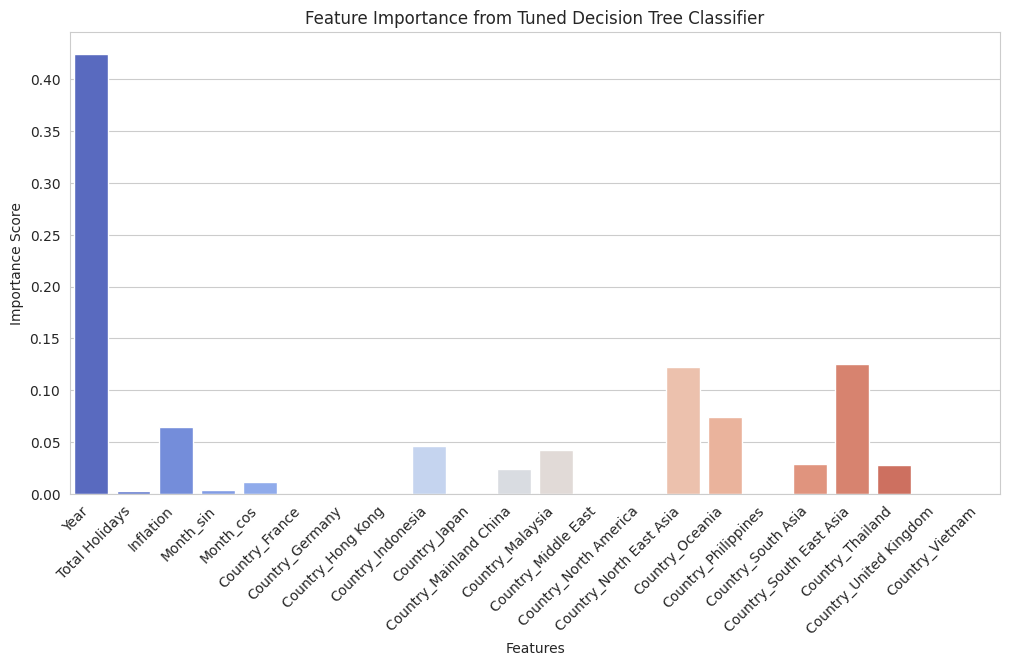

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Set visualization style for plots
sns.set_style("whitegrid")

# Load the training dataset
print("\nLoading and analyzing training dataset...")
df_train = pd.read_csv("train_data_with_traffic_class.csv")

# Display the number of rows in the dataset
print(f"Total number of rows: {df_train.shape[0]}")

# Display the first few rows of the dataset to understand its structure
print("\nDataset Overview:")
print(df_train.head(), "\n")

# Display summary statistics of the dataset, including count, mean, std, min, max, etc.
print("Dataset Summary:")
print(df_train.describe(), "\n")

# Display dataset info, such as data types and memory usage
print("Dataset Info:")
df_train.info()

# Define the feature set (X) and target variable (y)
# Dropping the columns that are not features for model training
X_train_full = df_train.drop(columns=["Total_Traffic", "Departures", "Arrivals", "Traffic_Class", "Month"])
y_train_full = df_train["Traffic_Class"]

# One-hot encoding of categorical variable "Country" into separate binary columns
X_train_full = pd.get_dummies(X_train_full, columns=["Country"], drop_first=True)

# Train an untuned Decision Tree model to serve as the baseline
print("\nTraining untuned Decision Tree model...")
untuned_model = DecisionTreeClassifier(random_state=42)
untuned_model.fit(X_train_full, y_train_full)

# Evaluate the untuned model on the training set
train_accuracy_untuned = untuned_model.score(X_train_full, y_train_full)
cv_scores_untuned = cross_val_score(untuned_model, X_train_full, y_train_full, cv=10)

# Display the performance of the untuned model
print("\nUntuned Model Performance:")
print(f"Training Accuracy: {train_accuracy_untuned:.4f}")
print(f"Cross-Validation Accuracy: Mean = {cv_scores_untuned.mean():.4f}, Std = {cv_scores_untuned.std():.4f}")

# Perform hyperparameter tuning using GridSearchCV to find the best model parameters
print("\nPerforming hyperparameter tuning with GridSearchCV...")
param_grid = {
    'max_depth': [6, 8, 10, 12, 15],  # Maximum depth of the tree
    'criterion': ['gini', 'entropy'],  # Function to measure the quality of a split
    'splitter': ['best', 'random'],  # Strategy for splitting at each node
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', None],  # Number of features to consider for the best split
    'min_weight_fraction_leaf': [0.0, 0.1, 0.2],  # Minimum weighted fraction of the input samples required to be at a leaf node
    'class_weight': ['balanced', None]  # Weights associated with classes to handle imbalanced data
}

# Use GridSearchCV to perform an exhaustive search over the specified parameter grid
grid_search = GridSearchCV(untuned_model, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_full, y_train_full)

# Output the best hyperparameters from GridSearchCV
print("\nBest Hyperparameters:", grid_search.best_params_)

# Train the tuned model with the best hyperparameters obtained from GridSearchCV
tuned_model = grid_search.best_estimator_
tuned_model.fit(X_train_full, y_train_full)

# Evaluate the performance of the tuned model on the training data
train_accuracy_tuned = tuned_model.score(X_train_full, y_train_full)
cv_scores_tuned = cross_val_score(tuned_model, X_train_full, y_train_full, cv=10)

# Display the performance of the tuned model
print("\nTuned Model Performance:")
print(f"Training Accuracy: {train_accuracy_tuned:.4f}")
print(f"Cross-Validation Accuracy: Mean = {cv_scores_tuned.mean():.4f}, Std = {cv_scores_tuned.std():.4f}")

# Load and preprocess the test dataset
print("\nLoading and preprocessing test dataset...")
df_test = pd.read_csv("test_data_with_traffic_class.csv")

# Prepare the test data by dropping the irrelevant columns and encoding categorical variables
X_test = df_test.drop(columns=["Total_Traffic", "Departures", "Arrivals", "Traffic_Class", "Month"])
y_test = df_test["Traffic_Class"]
X_test = pd.get_dummies(X_test, columns=["Country"], drop_first=True)

# Ensure the test set has the same columns as the training set (handle missing columns by filling with 0)
X_test = X_test.reindex(columns=X_train_full.columns, fill_value=0)

# Evaluate the untuned model on the test set
test_accuracy_untuned = accuracy_score(y_test, untuned_model.predict(X_test))
print("\nUntuned Model Performance on Test Set:")
print(f"Testing Accuracy: {test_accuracy_untuned:.4f}")

# Display confusion matrix for the untuned model's performance
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, untuned_model.predict(X_test)))

# Display classification report for the untuned model
print("\nClassification Report:")
print(classification_report(y_test, untuned_model.predict(X_test)))

# Evaluate the tuned model on the test set
test_accuracy_final = accuracy_score(y_test, tuned_model.predict(X_test))
print("\nFinal Model Performance on Test Set:")
print(f"Testing Accuracy: {test_accuracy_final:.4f}")

# Display confusion matrix for the tuned model's performance
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, tuned_model.predict(X_test)))

# Display classification report for the tuned model
print("\nClassification Report:")
print(classification_report(y_test, tuned_model.predict(X_test)))

# Feature Importance Plot: Show which features are most important for the final decision tree model
final_importances = tuned_model.feature_importances_

# Plot the feature importance using a barplot for better visualization
plt.figure(figsize=(12, 6))
sns.barplot(x=X_test.columns, y=final_importances, palette="coolwarm")
plt.xticks(rotation=45, ha="right")  # Rotate feature names for readability
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.title("Feature Importance from Tuned Decision Tree Classifier")
plt.show()

In [ ]:
import shap

# Create the SHAP explainer for the tuned Decision Tree model
explainer = shap.TreeExplainer(tuned_model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)
print("SHAP values shape:", np.array(shap_values).shape)
print("X_test shape:", X_test.shape)

SHAP values shape: (449, 22, 3)
X_test shape: (449, 22)


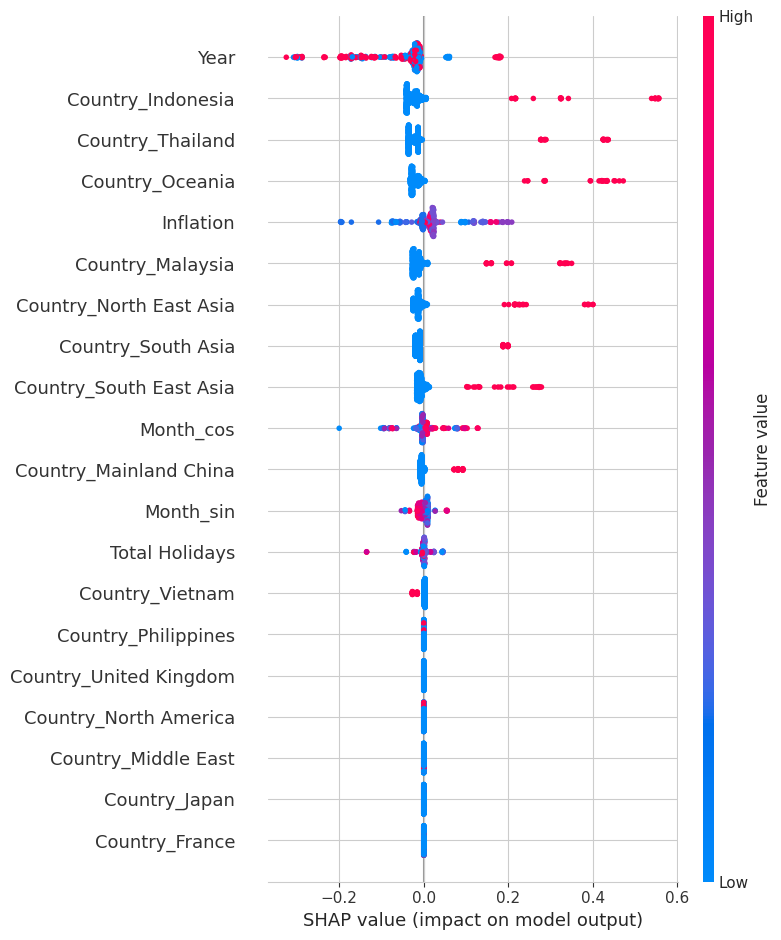

In [ ]:
# Plot SHAP summary plot for class 0
shap.summary_plot(shap_values[:, :, 0], X_test)

The SHAP analysis reveals that Year is the most influential feature in the model's predictions, with a wide spread of SHAP values indicating a substantial impact. More recent years drive the model’s output in a distinct direction compared to earlier years, emphasizing the temporal influence. Country-specific effects also play a critical role, with features such as Country_Indonesia, Country_Thailand, and Country_Oceania exhibiting broad SHAP distributions, suggesting that observations from these regions significantly shape predictions. Other regions, including Malaysia, North East Asia, South Asia, South East Asia, and Mainland China, also show moderate-to-high SHAP spreads, reinforcing the importance of geographical variations. Inflation ranks in the upper half of the SHAP plot, demonstrating the model’s sensitivity to economic fluctuations, while seasonality effects (captured by Month_sin and Month_cos) indicate that different times of the year influence predictions, albeit to a lesser extent than country indicators or Year. Total Holidays provides additional explanatory power but has a relatively minor impact compared to the dominant drivers. Less influential yet still relevant factors include country-specific indicators such as Vietnam, Philippines, United Kingdom, North America, Middle East, Japan, and France, which contribute to predictions but with lower SHAP values. Overall, the analysis highlights that the model is primarily driven by temporal trends (Year and seasonality), regional variations (country-specific factors), and economic conditions (inflation), confirming that it effectively captures both time-dependent and geographical influences.

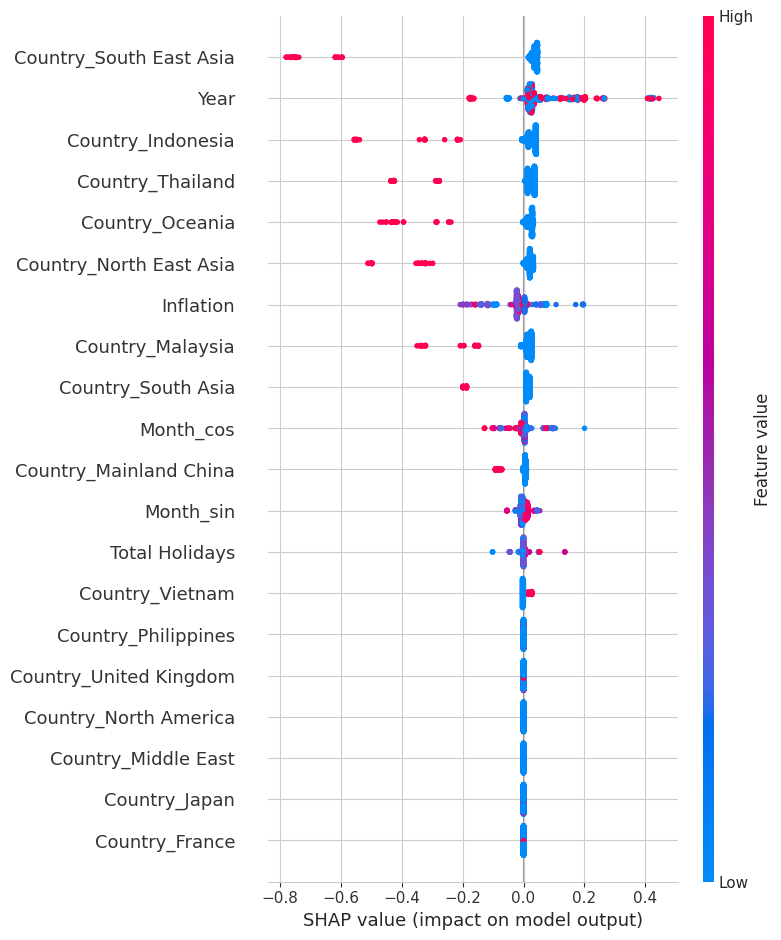

In [ ]:
# Plot SHAP summary plot for class 1
shap.summary_plot(shap_values[:, :, 1], X_test)

The SHAP analysis highlights a strong regional influence, with Country_South East Asia emerging as the most impactful geographical feature. Its broad SHAP value distribution suggests that whether a data point belongs to this region can significantly shift the model’s predictions in either direction. Other high-ranking country indicators, including Country_Indonesia, Country_Thailand, and Country_Oceania, further reinforce the critical role of location-based factors in shaping outcomes. Temporal trends also play a crucial role, with Year ranking near the top and exhibiting a substantial spread of SHAP values, indicating that shifts from one year to the next heavily influence predictions. Inflation follows closely, showing a notable impact with a moderately wide SHAP distribution, underscoring its significance as a key macroeconomic determinant. Seasonality effects, captured through Month_cos and Month_sin, have a moderate influence, reflecting time-of-year variations, though their impact is secondary to regional and temporal factors. While other country-level differences—such as those in Vietnam, Philippines, United Kingdom, North America, and others—exhibit smaller SHAP spreads, they still meaningfully contribute to refining predictions. Finally, Total Holidays has a smaller but noticeable effect, suggesting that the number of holidays influences outcomes, albeit to a lesser degree than macroeconomic or regional variables. In summary, the model’s predictions are predominantly shaped by regional effects (particularly South East Asia), temporal dynamics (Year), and macroeconomic conditions (Inflation), with seasonal and country-specific variations playing supporting roles.

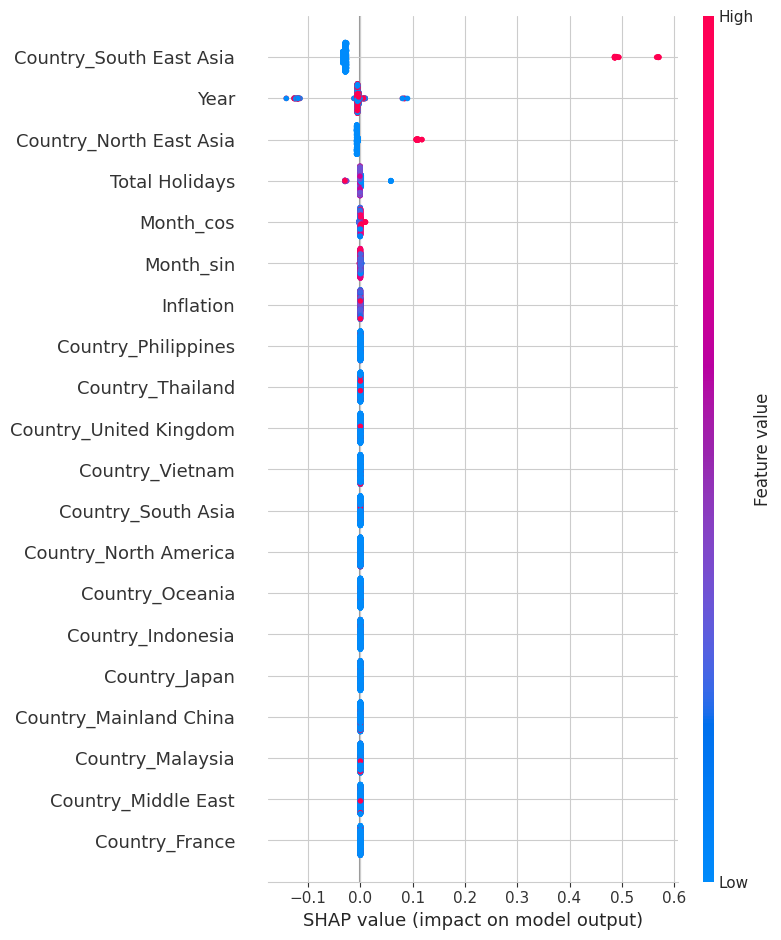

In [ ]:
# Plot SHAP summary plot for class 2
shap.summary_plot(shap_values[:, :, 2], X_test)

The SHAP analysis identifies Country_South East Asia as the most influential feature, with the widest SHAP value spread, indicating that observations from this region can significantly impact predictions in both positive and negative directions. Year follows as a key driver, with a moderate-to-large SHAP distribution, highlighting the substantial effect of temporal trends on the model’s output. Total Holidays ranks as the third most impactful factor, where higher holiday counts (represented by red points) push predictions upward, while lower counts (blue points) pull them downward. Seasonality and Inflation contribute moderately, with Month_cos and Month_sin capturing cyclical variations in the middle of the SHAP ranking, suggesting that time-of-year effects influence predictions but are secondary to regional and yearly trends. Inflation exhibits a small-to-moderate SHAP range, reflecting its role in shaping outcomes, albeit with a lesser effect than the top three features. Other country-specific factors, such as Country_Philippines, Country_Thailand, and Country_United Kingdom, show relatively lower SHAP spreads, indicating that while they contribute, their impact is less pronounced. Overall, the model’s predictions are primarily driven by regional influences (led by South East Asia), temporal trends (Year), and holiday counts, with seasonality, inflation, and country-level variations providing additional but smaller contributions.

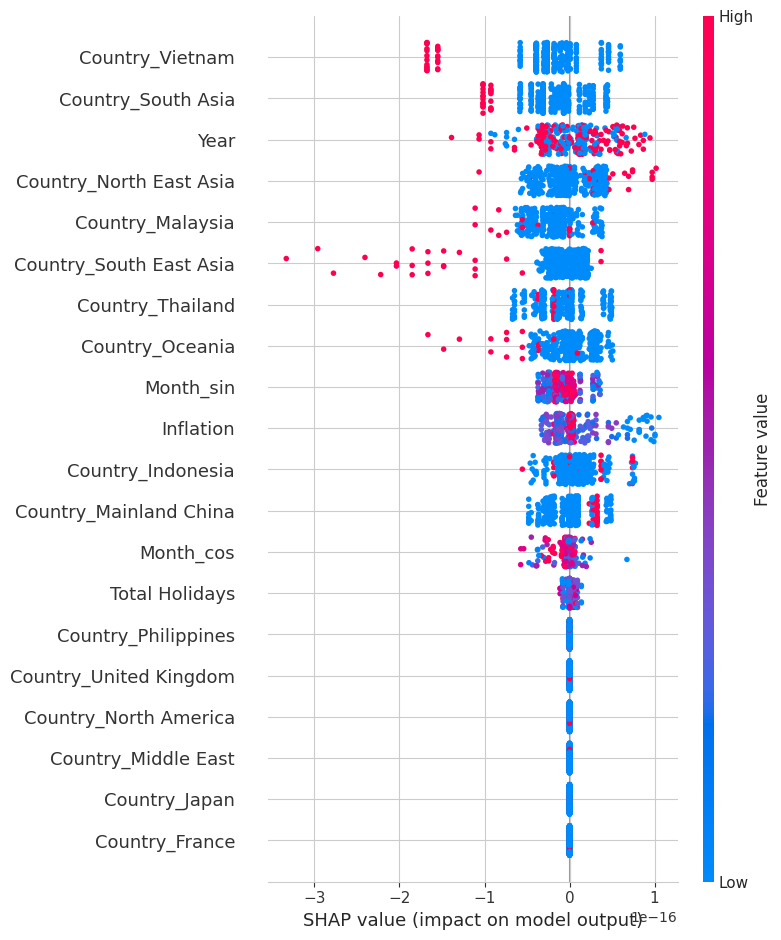

In [ ]:
# Convert the test set to a DataFrame to have original feature names for visualization
X_test_df = pd.DataFrame(X_test, columns=X_test.columns)

# Plot the mean SHAP values across all instances for each feature
shap.summary_plot(shap_values.mean(axis=2), X_test_df)

The SHAP analysis reveals that regional and country-based factors have the most significant impact on the model’s predictions, with Country_Vietnam and Country_South Asia emerging as the most influential features. The direction of influence is evident in the SHAP values, where Country_Vietnam predominantly exhibits positive values, indicating that its presence increases the predicted outcome. In contrast, Country_North America and Country_France have near-zero SHAP values, suggesting minimal contribution to the model’s decisions. The effect of feature values is further illustrated through color coding, where high values (red) and low values (blue) shape predictions differently. For instance, in Country_North East Asia, both high and low values impact predictions in varied ways, while in Country_Vietnam, high values consistently drive the output in one direction. Some features, such as Country_France and Country_Japan, show little variation in SHAP values, indicating negligible influence. Additionally, macroeconomic variables, including Inflation and Total Holidays, contribute relatively little compared to dominant country-based effects. Overall, the model’s predictions are primarily shaped by regional influences, with Vietnam and South Asia playing the most significant roles, while macroeconomic factors have a lower impact, and certain country-level features contribute minimally.

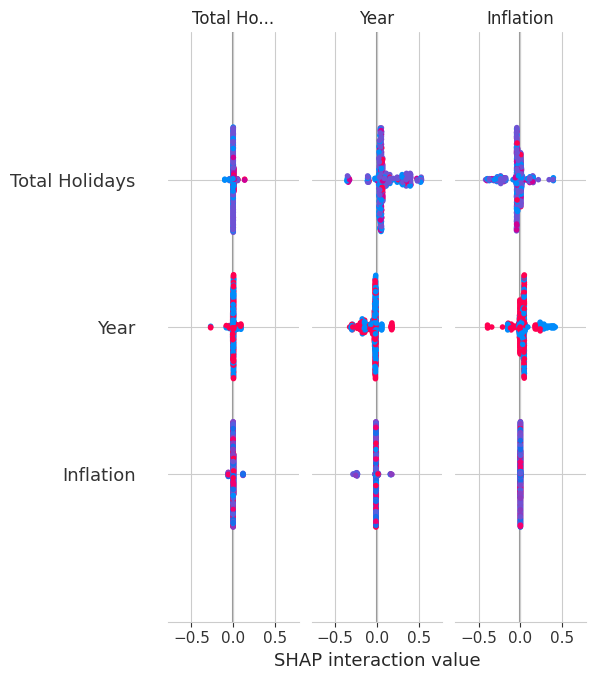

In [ ]:
# Bar plot for SHAP values per feature, showing the relative importance of each feature
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_type="bar")

The SHAP interaction analysis indicates that feature interactions are generally weak, as most interaction values cluster around zero, suggesting that key features such as Total Holidays, Year, and Inflation influence the model independently rather than amplifying or modifying each other’s effects. If strong interactions were present, a wider spread of SHAP values would be expected, which is not observed. Among the features analyzed, Total Holidays shows the most notable interaction effect, with its self-interaction (diagonal element) displaying a slightly broader SHAP distribution, indicating a moderate impact on predictions. However, its interactions with other variables remain minimal. Similarly, Year and Inflation exhibit negligible interaction, with SHAP values remaining close to zero, confirming that these features contribute independently to the model’s predictions. Additionally, the even distribution of positive (red) and negative (blue) SHAP values suggests that an increase in any given feature does not consistently lead to higher or lower predictions. This further reinforces the conclusion that the model’s predictions are primarily driven by individual feature contributions rather than interactions between variables.

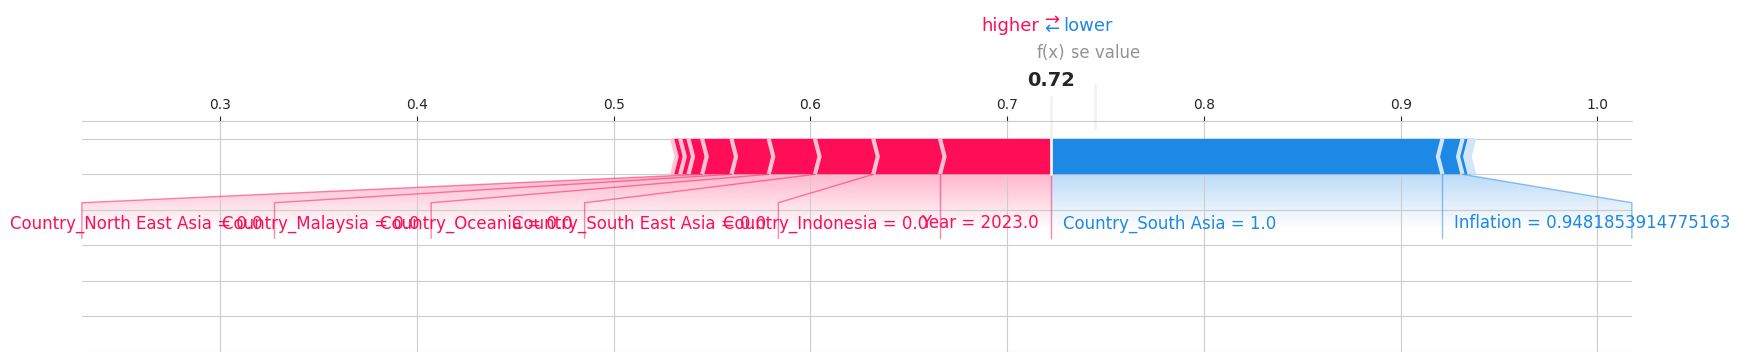

In [ ]:
# Convert X_test (NumPy array) to a DataFrame for easier indexing and understanding
X_test_df = pd.DataFrame(X_test, columns=X_test.columns)

# Select a class index (e.g., 1) to analyze the SHAP values for that specific class
class_index = 1  # Looking at class 1 (you can change this to 0 or 2 depending on the class you're interested in)

# Get SHAP values for the chosen class (e.g., class 1)
shap_values_class = shap_values[:, :, class_index]

# Get the expected value for the chosen class
expected_value_class = explainer.expected_value[class_index]

# Select an instance to analyze (for instance, the 6th instance in the test set)
instance_idx = 6

# Generate the SHAP force plot for the specific instance
shap.plots.force(expected_value_class, shap_values_class[instance_idx, :], X_test_df.iloc[instance_idx, :], matplotlib=True)

The SHAP waterfall plot provides a detailed breakdown of feature contributions, revealing that the final prediction of 0.72 results from the cumulative impact of various factors, each either increasing or decreasing the outcome. Regional influences play a dominant role, with Country_North East Asia, Country_Malaysia, Country_Oceania, Country_South East Asia, and Country_Indonesia acting as key positive contributors, pushing the prediction higher. Additionally, Year = 2023 further boosts the model’s output, emphasizing the role of temporal trends. On the other hand, negative contributors such as Country_South Asia and Inflation pull the prediction downward, with inflation having a particularly strong suppressing effect, indicating that higher inflation levels reduce the predicted outcome. This analysis underscores the model’s reliance on geographical factors, where certain regions drive predictions upward while others exert downward pressure. At the same time, economic conditions—particularly inflation—act as a counterbalancing force, significantly lowering the final prediction. The presence of Year = 2023 among the positive contributors further highlights the temporal relevance of the model. In summary, the interaction between regional influences, economic indicators, and temporal trends plays a crucial role in shaping predictions, reinforcing the importance of considering these factors for accurate model interpretation and decision-making.

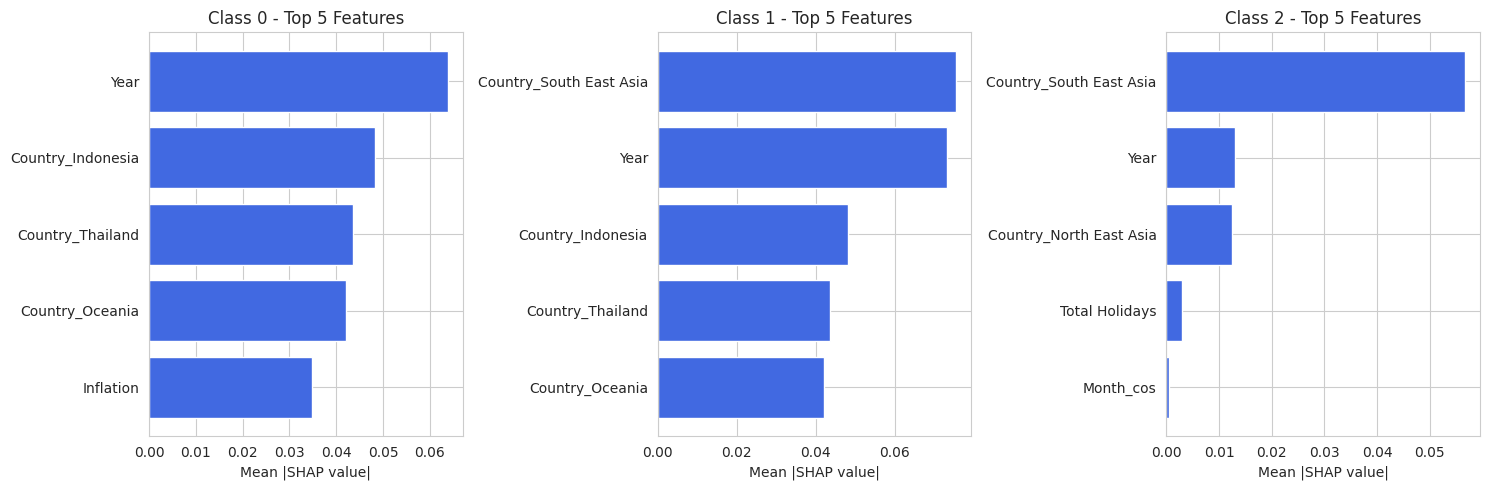

In [ ]:
# Compute mean absolute SHAP values for each class to determine feature importance
num_classes = shap_values.shape[2]  # Number of classes (e.g., 3 for a 3-class problem)
feature_importance_per_class = {}

# Calculate the mean absolute SHAP values for each feature, per class
for class_idx in range(num_classes):
    mean_abs_shap = np.abs(shap_values[:, :, class_idx]).mean(axis=0)  # Mean absolute SHAP value per feature
    feature_importance_per_class[class_idx] = mean_abs_shap

# Get feature names from the test set for labeling the plots
feature_names = X_test.columns.tolist()

# Store the top 5 features for each class based on the mean absolute SHAP values
top_features_per_class = {}

for class_idx in range(num_classes):
    # Get the indices of the top 5 features with the highest mean absolute SHAP values
    top_indices = np.argsort(feature_importance_per_class[class_idx])[-5:]
    # Store the top 5 feature names for the class
    top_features_per_class[class_idx] = [feature_names[i] for i in top_indices]

# Create a figure with subplots for each class
fig, axes = plt.subplots(1, num_classes, figsize=(15, 5))

# For each class, plot the top 5 features based on the mean absolute SHAP values
for class_idx in range(num_classes):
    top_features = top_features_per_class[class_idx]
    top_importance = feature_importance_per_class[class_idx][np.argsort(feature_importance_per_class[class_idx])[-5:]]

    # Create a horizontal bar plot to show the top 5 features for the class
    ax = axes[class_idx]
    ax.barh(top_features, top_importance, color='royalblue')
    ax.set_xlabel("Mean |SHAP value|")  # Label the x-axis as "Mean SHAP value"
    ax.set_title(f"Class {class_idx} - Top 5 Features")  # Title indicating the class

# Adjust layout for better visualization and display the plots
plt.tight_layout()
plt.show()

The SHAP summary bar charts reveal distinct patterns in feature importance across classes, highlighting the dominant role of temporal and geographical factors in the model’s predictions. The Year feature consistently ranks among the top predictors for all three classes, emphasizing the influence of temporal trends. Additionally, country-related features—such as Country_Indonesia, Country_Thailand, Country_Oceania, Country_South East Asia, and Country_North East Asia—demonstrate strong geographical dependencies across different classes. Class-specific insights further refine this understanding: In Class 0, Year is the most influential feature, followed by Country_Indonesia, Country_Thailand, and Country_Oceania, with Inflation appearing among the top five, suggesting an economic influence on this category. In Class 1, Country_South East Asia emerges as the dominant feature, while Year remains highly significant alongside Country_Indonesia, Country_Thailand, and Country_Oceania, reinforcing the importance of regional factors. In Class 2, Country_South East Asia again plays the most critical role, but Year becomes less impactful, with Country_North East Asia, Total Holidays, and Month_cos gaining prominence, indicating that seasonal patterns are particularly relevant for this class. Geographical and temporal effects vary by class, with South East Asia exerting the strongest influence in Class 1 and Class 2, while Inflation affects only Class 0, suggesting that macroeconomic conditions impact some categories more than others. Additionally, seasonality effects—captured by Month_cos and Total Holidays—are uniquely relevant for Class 2, highlighting the importance of time-of-year patterns in shaping predictions. Overall, the model’s decisions are primarily driven by regional factors and temporal trends, while economic conditions influence only specific classes, underscoring the need to consider class-specific variations for accurate model interpretation and refinement.